In [1]:
import pandas as pd
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

seed = 7

data = pd.read_csv('mimiciii_sepsis.csv').drop(['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID'], axis=1)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)

X = data.drop(['28 Day Death', 'In Hospital Death'], axis=1)
y = data['28 Day Death']

for column in X.columns:
    X[column] = pd.to_numeric(X[column])
    X[column] = X[column].fillna(X[column].mean())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)


In [2]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [3]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h


# Descriptive Statistics

In [2]:
from tableone import TableOne, load_dataset
import pandas as pd

data_filtered = data.drop(['In Hospital Death'], axis=1)
columns = list(data_filtered.columns.values)
groupby = ['28 Day Death']
nonnormal = ['Age']
# labels={'28 Day Death': 'Mortality'}
mytable = TableOne(data_filtered, columns=columns, groupby=groupby, nonnormal=nonnormal, pval=True)
mytable

Grouped by 28 Day Death                                                                 
                                                                     Missing            Overall                  0                  1 P-Value
n                                                                                          4555               2820               1735        
Age, median [Q1,Q3]                                                        0   68.5 [55.9,80.2]   66.2 [53.9,78.5]   72.2 [59.7,82.7]  <0.001
Gender, n (%)                                  0                           0        2029 (44.5)        1290 (45.7)         739 (42.6)   0.041
                                               1                                    2526 (55.5)        1530 (54.3)         996 (57.4)        
LOS, mean (SD)                                                             0        15.3 (17.1)        15.9 (16.9)        14.3 (17.5)   0.002
Hypertension, n (%)                            0.0                       124        2771 (62.5)        1751 (62.4)        1020 (62.7)   0.896
                                               1.0                                  1660 (37.5)        1053 (37.6)         607 (37.3)        
Hyperlipidemia, n (%)                          0.0                       124        4253 (96.0)        2667 (95.1)        1586 (97.5)  <0.001
                                               1.0                                    178 (4.0)          137 (4.9)           41 (2.5)        
Diabetes, n (%)                                0.0                       124        4141 (93.5)        2613 (93.2)        1528 (93.9)   0.379
                                               1.0                                    290 (6.5)          191 (6.8)           99 (6.1)        
Hematocrit, mean (SD)                                                      6         33.9 (6.4)         34.1 (6.2)         33.4 (6.6)  <0.001
Hematocrit, Calculated, mean (SD)                                       2654         31.4 (6.7)         31.7 (6.5)         31.0 (7.0)   0.033
Hemoglobin, mean (SD)                                                      7         11.3 (2.2)         11.4 (2.2)         11.0 (2.2)  <0.001
Red Blood Cells, mean (SD)                                                10          3.7 (0.8)          3.8 (0.7)          3.6 (0.8)  <0.001
Nucleated Red Cells, mean (SD)                                          3651         4.1 (14.2)          2.4 (4.1)         5.4 (18.1)  <0.001
RDW, mean (SD)                                                             9         15.8 (2.4)         15.4 (2.2)         16.6 (2.6)  <0.001
MCH, mean (SD)                                                            10         30.3 (3.0)         30.1 (2.9)         30.5 (3.2)  <0.001
MCHC, mean (SD)                                                            8         33.2 (1.6)         33.3 (1.6)         32.9 (1.7)  <0.001
MCV, mean (SD)                                                            10         91.3 (8.2)         90.4 (7.7)         92.7 (8.8)  <0.001
White Blood Cells, mean (SD)                                               7        14.2 (12.0)        14.1 (11.6)        14.4 (12.7)   0.527
Lymphocytes, mean (SD)                                                   123        10.8 (11.8)        10.7 (11.6)        10.9 (12.2)   0.601
Lymphs, mean (SD)                                                       4287        49.1 (32.6)        50.5 (32.1)        46.1 (33.8)   0.317
Basophils, mean (SD)                                                     137          0.2 (0.4)          0.2 (0.5)          0.2 (0.4)   0.263
Eosinophils, mean (SD)                                                   166          0.9 (2.4)          0.8 (2.0)          0.9 (2.9)   0.346
Neutrophils, mean (SD)                                                   137        77.6 (17.5)        78.1 (16.5)        76.7 (18.9)   0.009
Monocytes, mean (SD)                                                     130 

In [12]:
mytable.to_csv('summary_28_death.csv')

/Users/llja0112/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Logistic Regression



In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

estimators = [('Scaler', StandardScaler()), ('Log_Reg', LogisticRegression(random_state=seed, solver='liblinear'))]
pipe = Pipeline(estimators)

clf = pipe.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.8123929571466114
Average Precision: 0.748206340300866
Accuracy: 0.7600585223116313


In [29]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

predictions = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:, 1]

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]
    
    # scores_bs = scores[X_test_bs.index]
    probs_bs = probs[X_test_bs.index]
    predictions_bs = predictions[X_test_bs.index]

    # scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs_bs)
    auprc = average_precision_score(y_test_bs, probs_bs)
    accuracy = accuracy_score(y_test_bs, predictions_bs)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.8199049730757048, 0.812667940363127, 0.8271420057882826, 0.007237032712577791)
(0.765024286168822, 0.7557855548512731, 0.7742630174863709, 0.009238731317548916)
(0.7658, 0.7585069825633596, 0.7730930174366405, 0.0072930174366405065)


# Gradient Boosting

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    'n_estimators': [160, 180, 200, 220], 
    'max_depth':[1, 3, 5]
}

GBoost = GradientBoostingClassifier(random_state=seed)
clf = GridSearchCV(GBoost, parameters, scoring='roc_auc')
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)


{'max_depth': 5, 'n_estimators': 180}
0.8565293211001734


In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(n_estimators=180, max_depth=5, random_state=seed).fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.8783970530932552
Average Precision: 0.8385398366600897
Accuracy: 0.8039502560351134


In [31]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

predictions = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:, 1]

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]
    
    # scores_bs = scores[X_test_bs.index]
    probs_bs = probs[X_test_bs.index]
    predictions_bs = predictions[X_test_bs.index]

    # scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs_bs)
    auprc = average_precision_score(y_test_bs, probs_bs)
    accuracy = accuracy_score(y_test_bs, predictions_bs)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.8831464470488861, 0.8783409867684937, 0.8879519073292785, 0.0048054602803923804)
(0.849891237484518, 0.8428079062915634, 0.8569745686774726, 0.007083331192954527)
(0.8093, 0.8031159940316187, 0.8154840059683813, 0.006184005968381297)


# Random Forest

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators': [220, 240, 260, 300, 340], 
    'max_depth':[1, 3, 5]
}

RanFor = RandomForestClassifier(n_estimators=110, max_depth=7, random_state=seed)
clf = GridSearchCV(RanFor, parameters, scoring='roc_auc')
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 5, 'n_estimators': 340}
0.8221197133661826


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=140, max_depth=5, random_state=seed)
clf.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.829528875517657
Average Precision: 0.7764061556474027
Accuracy: 0.7425018288222385


In [33]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

predictions = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:, 1]

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]
    
    # scores_bs = scores[X_test_bs.index]
    probs_bs = probs[X_test_bs.index]
    predictions_bs = predictions[X_test_bs.index]

    # scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs_bs)
    auprc = average_precision_score(y_test_bs, probs_bs)
    accuracy = accuracy_score(y_test_bs, predictions_bs)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.8334009080350545, 0.8262795919328006, 0.8405222241373084, 0.00712131610225382)
(0.7857272241072286, 0.7760074099061498, 0.7954470383083074, 0.009719814201078765)
(0.7458, 0.7398306233284224, 0.7517693766715776, 0.0059693766715776)


In [11]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

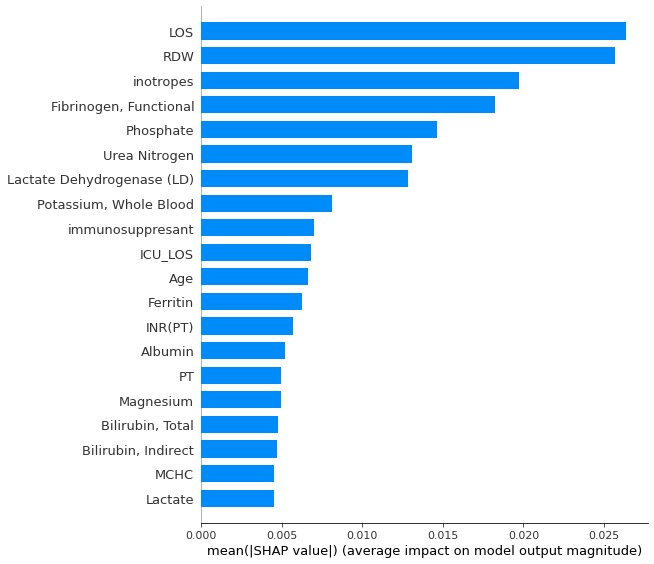

In [12]:
shap.summary_plot(shap_values[1], X, plot_type="bar")

# Neural Networks

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

estimators = [('Scaler', StandardScaler()), 
              ('Neural_Network', MLPClassifier(
                  random_state=seed, 
                  activation='logistic', 
                  solver='sgd', 
                  max_iter=1000))]
pipe = Pipeline(estimators)

parameters = {
    'Neural_Network__hidden_layer_sizes': [(50), (80), (100), (120)]
}

clf = GridSearchCV(pipe, parameters, scoring='roc_auc')
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'Neural_Network__hidden_layer_sizes': 100}
0.792613424680877


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

estimators = [('Scaler', StandardScaler()), 
              ('Neural_Network', MLPClassifier(
                  hidden_layer_sizes=(100),
                  random_state=seed, 
                  activation='logistic', 
                  solver='sgd', 
                  max_iter=1000))]
pipe = Pipeline(estimators)

pipe.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, pipe.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, pipe.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.8054312071262223
Average Precision: 0.7311933074904147
Accuracy: 0.7534747622531089


In [28]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

predictions = pipe.predict(X_test)
probs = pipe.predict_proba(X_test)[:, 1]

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]
    
    # scores_bs = scores[X_test_bs.index]
    probs_bs = probs[X_test_bs.index]
    predictions_bs = predictions[X_test_bs.index]

    # scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs_bs)
    auprc = average_precision_score(y_test_bs, probs_bs)
    accuracy = accuracy_score(y_test_bs, predictions_bs)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.81295744905501, 0.805772241329933, 0.820142656780087, 0.007185207725076973)
(0.7477211404599216, 0.7378243668503451, 0.757617914069498, 0.00989677360957638)
(0.76, 0.7526471086337699, 0.7673528913662301, 0.007352891366230093)


In [20]:
import shap

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

explainer = shap.KernelExplainer(pipe.predict, X_train[:50].values)
shap_values = explainer.shap_values(X_test.values, nsamples=500)


  0%|          | 0/1367 [00:00<?, ?it/s]

In [36]:
shap_values

array([[ 0.00786208,  0.00901361,  0.        , ..., -0.06720624,
         0.05710933, -0.02560792],
       [ 0.        ,  0.        ,  0.01807418, ..., -0.00391495,
        -0.07771597, -0.02211828],
       [-0.02941796,  0.00526275,  0.02747771, ..., -0.01311345,
        -0.13817497,  0.        ],
       ...,
       [ 0.03959156, -0.00425989,  0.0294009 , ..., -0.00256345,
        -0.14470767,  0.        ],
       [ 0.11084023, -0.04702837, -0.10977892, ...,  0.        ,
         0.11031366, -0.07043524],
       [ 0.02120194,  0.00424944,  0.00194474, ..., -0.01409941,
        -0.16799205, -0.0401091 ]])

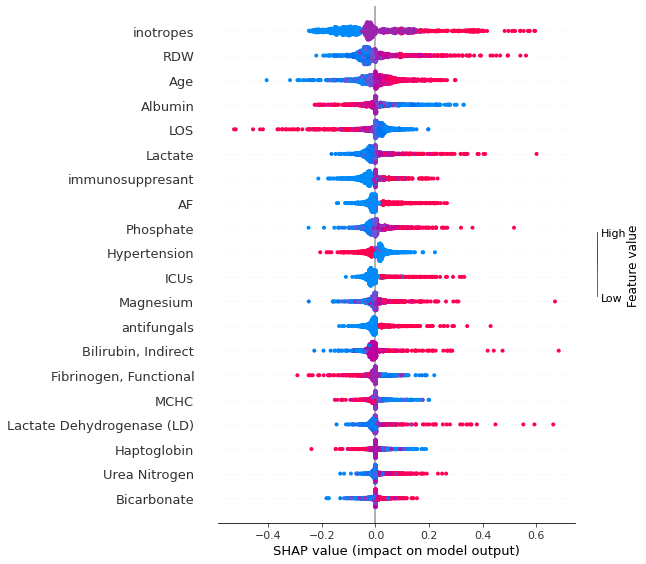

In [25]:
shap.summary_plot(shap_values, X_test)

# Post processing required for risk slim baseline 

In [ ]:
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = data.drop(['28 Day Death', 'In Hospital Death'], axis=1)
y = data['28 Day Death']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)

imp = IterativeImputer(max_iter=10, random_state=seed)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

top_n = 10
scaler = MinMaxScaler()
kbest = SelectKBest(chi2, k=top_n)
scaler.fit(X_train)

X_train = kbest.fit_transform(scaler.transform(X_train), y_train)
X_test = kbest.transform(scaler.transform(X_test))

X_train = pd.DataFrame(X_train, columns=X.columns[kbest.get_support()])
X_test = pd.DataFrame(X_test, columns=X.columns[kbest.get_support()])

# data_train = pd.read_csv('data_train.csv')
# X = data_train.iloc[:, 1:]
# y = data_train.iloc[:, :1]

# kbest.fit(scaler.fit_transform(X_train), y_train)
# variables = X.columns[kbest.get_support()]


X_train.insert(0, '28 Day Death', y_train)
X_train.to_csv('data_train.csv', index=False)
X_test.insert(0, '28 Day Death', y_test)
X_test.to_csv('data_test.csv', index=False)
